In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
data = json.load(open("SFdata//HX.json"))

pixscale = 0.26 # arcsec
pixscale *= 2.4              # parsec
s0 = 2.4/2.355                    # parsec
m = 1.4

In [4]:
r = pixscale * 10**np.array(data["log10 r"])
rgrid = pixscale * np.logspace(0.0, 2)

B = np.array(data["Unweighted B(r)"])

sig2 = data["Unweighted sigma^2"]
r0 = np.interp(sig2, B, r)

(12.895954004824253, 3.5486155706891322)

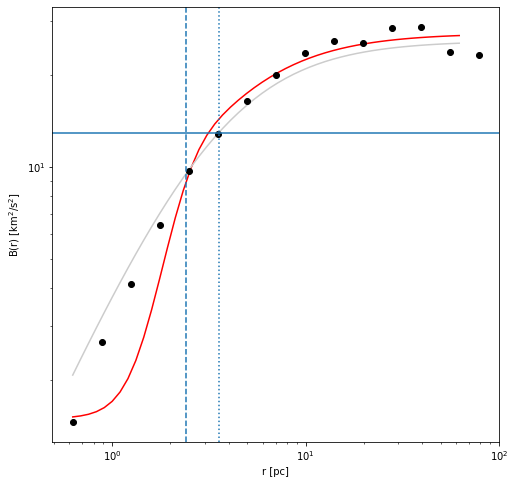

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axvline(2.355 * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")

ax.set(
    xscale = "log",
    yscale = "log",
#    ylim  = [1, 250],
#    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

sig2,r0

In [6]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [7]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [8]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=1.0)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [9]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1.0, sig2=sig2
)

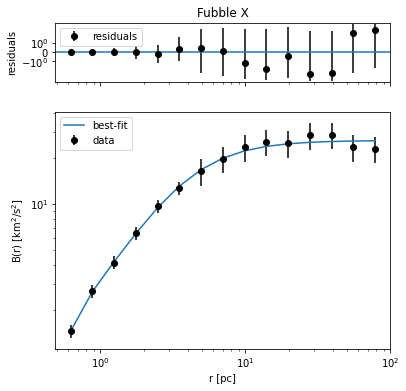

In [10]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title='Fubble X',
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('SFpaper//Hubble X.pdf', bbox_inches='tight')

In [11]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 15
    # variables        = 5
    chi-square         = 1.47372792
    reduced chi-square = 0.14737279
    Akaike info crit   = -24.8038252
    Bayesian info crit = -21.2635742
[[Variables]]
    r0:     3.61030000 +/- 0.21415404 (5.93%) (init = 3.548616)
    sig2:   12.7758492 +/- 0.99310982 (7.77%) (init = 12.89595)
    m:      1.72432356 +/- 0.25831239 (14.98%) (init = 1.4)
    s0:     0.29036471 +/- 0.17197965 (59.23%) (init = 1.019108)
    noise:  0.66919363 +/- 1.28757177 (192.41%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  0.995
    C(m, noise)    =  0.962
    C(m, s0)       =  0.940
    C(sig2, m)     = -0.926
    C(sig2, noise) = -0.897
    C(sig2, s0)    = -0.882
    C(r0, s0)      =  0.492
    C(r0, noise)   =  0.458
    C(r0, m)       =  0.239


In [12]:
#for p in result2.model.param_names:
#    result2.params[p].stderr = result2.params[p].value * 0.1

In [13]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(s0=0.0) = 0.8870487474561656 < max(sigmas)
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.680422568840368 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.63958  -0.39230  -0.19085   3.61030  +0.21690  +0.50870  +0.99331
 sig2 :  -1.82943  -1.11005  -0.54933  12.77585  +0.69612  +1.44469  +2.29869
 m    :  -0.35714  -0.26189  -0.16340   1.72432  +0.11205  +0.22687  +0.38890
 s0   :      -inf      -inf  -0.07051   0.29036  +0.06705  +0.11751  +0.18219
 noise:      -inf      -inf      -inf   0.66919  +0.38184  +0.57551  +0.76116


In [14]:
plt.style.use([
    "seaborn-poster",
])

In [15]:
plot_limits = {
    "s0": [0.0, 1],
    "m": [1.4, 2.0],
    "r0": [2.0, 5.0],
    "noise": [0.0, 2.0],
}

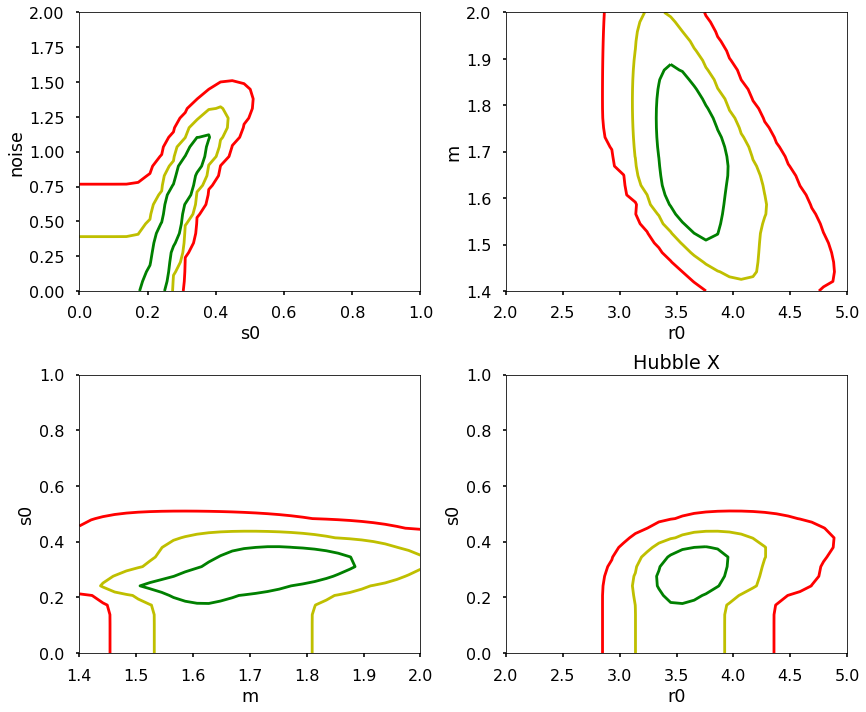

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('Hubble X')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
x=r
y=B-2*sig2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
SFr

array([21.99942771, 49.35656392])

In [18]:
r.max()/result2.params['r0'].value

21.759118543980026

In [19]:
(r[0]/2**0.5)*((result2.params['r0'].value/r[0])**(result2.params['m'].value/2))

2.0042233936319795

In [20]:
f = open('CI//HX.pkl',"wb")
pickle.dump(result2,f)
f.close()

In [21]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 42.130873680114746 seconds ---
